<a href="https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/mechanistic_interpretation/mechanistic_interp_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment
# Mechanistic Interp
### Eleanor Jiang


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meovvmiao/aipi-590-xai/blob/mechanistic_interpretation.ipynb)

This notebook starts with the example from the class, and followed by my solution in the second section.


In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI" # Change to your repo name
git_path = 'https://github.com/meovvmiao/AIPI-590-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'mechanistic_interpretation'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'AIPI-590-XAI'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 124 (delta 44), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 7.68 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/AIPI-590-XAI/adversarial_patch/AIPI-590-XAI/mechanistic_interpretation
1.txt


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb)

# Example Notebook for Mechanistic Interpretability Assignment

Use this notebook as starter code for your Mechanistic Interpretability assignment. You should build your own tiny model on a tiny problem.

This could be:

* Counting 1s in binary strings (like shown here)

* Reversing short character sequences

* XOR or parity classification

* Or any other toy task you design yourself!


**Methods shown in this notebook:**
* Training a small MLP to solve a regression task (predicting the count of 1s)

* Visualizing hidden layer activations averaged by input type (number of 1s)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

**Additional methods you can try for your problem:**
* Inspecting activations for specific inputs (not just averaged)

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

* Perturbing inputs (e.g., flipping bits) to observe model robustness

* Comparing intermediate representations across training checkpoints

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

In [4]:
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(binary_str)
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)

### Build a Tiny MLP (multilayer perceptron) Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated Model for Regression
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # for interpretability

# Instantiate model
model = CountingMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")


CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.11440877616405487
Validation MAE: 0.27
Rounded Accuracy: 0.88


### Print Activations of a sample input

In [6]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")


Sample Input: tensor([[1., 0., 1., 0., 1., 1., 0., 0.]])
Hidden Layer Activations: tensor([[1.2286, 1.0226, 1.3722, 1.2609, 1.1192, 0.0000, 0.0000, 0.0000, 1.4881,
         2.2109]])
Output Logits: tensor([[4.1658]])
Rounded Prediction: 4


### Plot hidden activations across different numbers of 1s as input

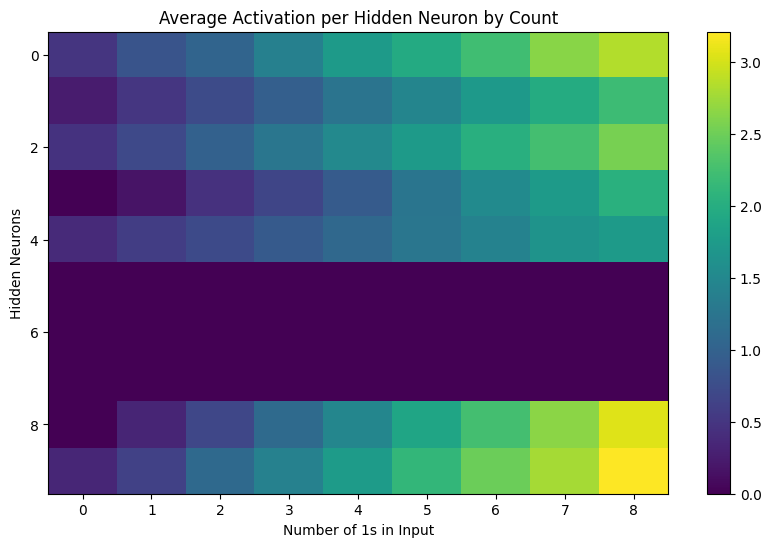

In [7]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, 10))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()

#### **What does this plot show us?**

##### *Neuron Specialization*
Look for rows (neurons) that are brightest at specific counts.

If a neuron appears consistently dark, that could mean it is unused or suppressed.

##### *Monotonic Trends*
If neurons show a gradual increase in activation with count — they may be learning a linear or thresholded count pattern.

That’s a great example of linearly increasing features often discussed in mechanistic interpretability (e.g. linear probe-ability).

##### *Redundant or Silent Units*
Some neurons may appear flatlined which possibly means they are unused due to redundancy. *What happens if you remove the neuron entirely?*

##### *Activation Superposition*
Some neurons activate across a range of counts, possibly blending multiple input features — this ties into superposition theory (see: Toy Models of Superposition)

_____________________

### Neuron Ablation (single neuron)

In [8]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)  # Example: 4 ones
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

# Zero out one neuron in the hidden layer (e.g., neuron 3)
neuron_to_zero = 3

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0  # zeroing neuron
    modified_output = model.fc2(h)
    modified_pred = modified_output.item()


print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")


True count: 4
Prediction (normal): 4.06
Prediction (with neuron 3 zeroed): 3.48
➖ Prediction decreased by 0.58


#### **What does the ablation tell us?**

If the prediction changes significantly after zeroing out a neuron, that neuron likely plays an important functional role in the model’s decision!

### Neuron Ablation (sweep of neurons)

🧾 True count: 4, Baseline prediction: 4.06


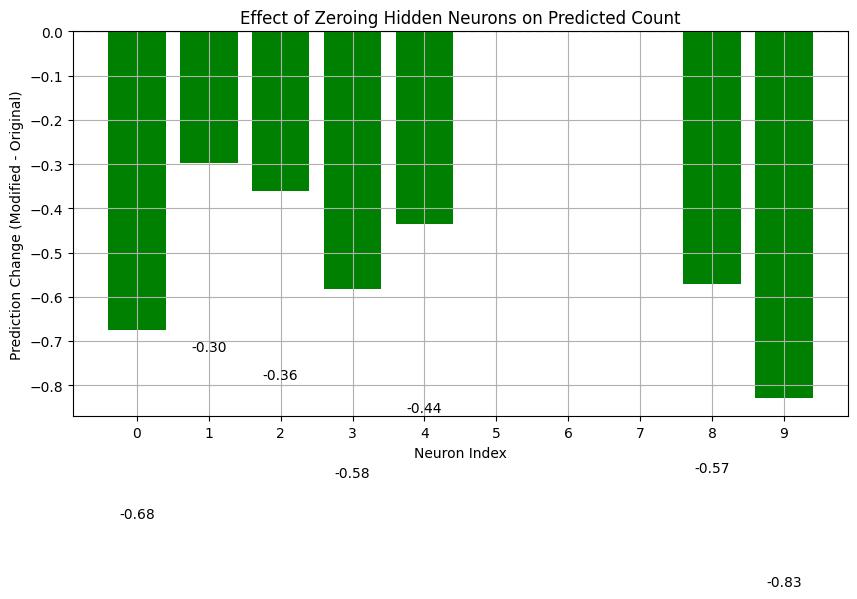

Neuron 0 → Prediction decreased by 0.68
Neuron 1 → Prediction decreased by 0.30
Neuron 2 → Prediction decreased by 0.36
Neuron 3 → Prediction decreased by 0.58
Neuron 4 → Prediction decreased by 0.44
Neuron 8 → Prediction decreased by 0.57
Neuron 9 → Prediction decreased by 0.83


In [9]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction
neuron_indices = list(range(model.fc1.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(test_input))
        h[:, i] = 0  # zero out neuron i
        mod_output = model.fc2(h)
        mod_pred = mod_output.item()
        signed_deltas.append(mod_pred - baseline_pred)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
plt.grid(True)

# Annotatation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top')

plt.show()

# Summary
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")


#### **What does the sweep of neuron ablations tell us?**

Which neurons had the most impact on predictions?

Are there redundant neurons (zeroing them causes no change)?

# My proposal: Solving the N-bit parity problem

In [13]:
import torch
import random

# Create the toy dataset
def generate_nBit_dataset(n_samples=10000, n_bits=8):
  X = []
  y = []
  for _ in range(n_samples):
      binary_str = torch.randint(0, 2, (n_bits,), dtype=torch.float32) # Generate a binary tensor
      parity = int(torch.sum(binary_str).item() % 2) # Calculate parity (0 for even, 1 for odd)
      X.append(binary_str)
      y.append(parity)
  return torch.stack(X), torch.tensor(y, dtype=torch.long)

# Instantiate the dataset
n_bits = 8
X_train_parity, y_train_parity = generate_nBit_dataset(2000, n_bits)
X_val_parity, y_val_parity = generate_nBit_dataset(500, n_bits)

In [12]:
X_train

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 1.]])

In [ ]:
# Build a classification model
class ParityMLP(nn.Module):
  def __init__(self, input_dim, hidden_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar

  def forward(self, x):
      h = F.relu(self.fc1(x))
      out = self.fc2(h)
      return out, h  # for interpretability

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Build a classification model
class ParityMLP(nn.Module):
  def __init__(self, input_dim, hidden_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar for binary classification (logits)

  def forward(self, x):
      h = F.relu(self.fc1(x))
      out = self.fc2(h)
      return out, h  # for interpretability


In [18]:
# Instantiate the ParityMLP model
parity_model = ParityMLP(input_dim=n_bits, hidden_dim=32)
print(parity_model)

# Convert targets to float for BCEWithLogitsLoss and unsqueeze for consistency
y_train_parity_float = y_train_parity.float().unsqueeze(1)
y_val_parity_float = y_val_parity.float().unsqueeze(1)

# Training loop with BCEWithLogitsLoss for binary classification
optimizer_parity = torch.optim.Adam(parity_model.parameters(), lr=0.01)
criterion_parity = nn.BCEWithLogitsLoss() # Combines Sigmoid and BCELoss for numerical stability

losses_parity = []
accuracies_parity = []

for epoch in range(500): # More epochs might be needed for parity problem
    parity_model.train()
    logits, _ = parity_model(X_train_parity)
    loss = criterion_parity(logits, y_train_parity_float)

    optimizer_parity.zero_grad()
    loss.backward()
    optimizer_parity.step()
    losses_parity.append(loss.item())

    # Calculate accuracy during training for monitoring
    with torch.no_grad():
        preds = (torch.sigmoid(logits) > 0.5).long()
        accuracy = (preds == y_train_parity_float.long()).float().mean().item()
        accuracies_parity.append(accuracy)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {losses_parity[-1]:.4f}, Train Accuracy: {accuracies_parity[-1]:.4f}")

print(f"Final training loss: {losses_parity[-1]:.4f}")
print(f"Final training accuracy: {accuracies_parity[-1]:.4f}")


ParityMLP(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 50, Loss: 0.6306, Train Accuracy: 0.6760
Epoch 100, Loss: 0.4847, Train Accuracy: 0.8490
Epoch 150, Loss: 0.3463, Train Accuracy: 0.9225
Epoch 200, Loss: 0.2400, Train Accuracy: 0.9580
Epoch 250, Loss: 0.1758, Train Accuracy: 0.9685
Epoch 300, Loss: 0.1357, Train Accuracy: 0.9890
Epoch 350, Loss: 0.1094, Train Accuracy: 0.9905
Epoch 400, Loss: 0.0901, Train Accuracy: 0.9925
Epoch 450, Loss: 0.0758, Train Accuracy: 0.9965
Epoch 500, Loss: 0.0637, Train Accuracy: 0.9965
Final training loss: 0.0637
Final training accuracy: 0.9965


Here I experimented different combination of #hidden layers and #epochs. From 500 to 1000 epochs, the model just improve 3% in accuracy, indicating a diminishing benefit in increasing the epochs. By increasing the number of hidden layers from 10, 16, to 32, the accuracy drastically increases.

In [19]:
# Evaluation on validation set
parity_model.eval()
with torch.no_grad():
    val_logits, _ = parity_model(X_val_parity)
    val_preds = (torch.sigmoid(val_logits) > 0.5).long()
    val_accuracy = (val_preds == y_val_parity_float.long()).float().mean().item()

print(f"Validation Accuracy for Parity Problem: {val_accuracy:.4f}")


Validation Accuracy for Parity Problem: 0.9900


The model is proven robust and accurate!

In [24]:
even_parity_inputs = X_val_parity[y_val_parity == 0]
odd_parity_inputs = X_val_parity[y_val_parity == 1]

print(f"Number of even parity inputs: {even_parity_inputs.shape[0]}")
print(f"Number of odd parity inputs: {odd_parity_inputs.shape[0]}")

Number of even parity inputs: 252
Number of odd parity inputs: 248


In [27]:
parity_model.eval()
with torch.no_grad():
    _, even_activations = parity_model(even_parity_inputs)
    avg_even_activations = even_activations.mean(dim=0)

    _, odd_activations = parity_model(odd_parity_inputs)
    avg_odd_activations = odd_activations.mean(dim=0)

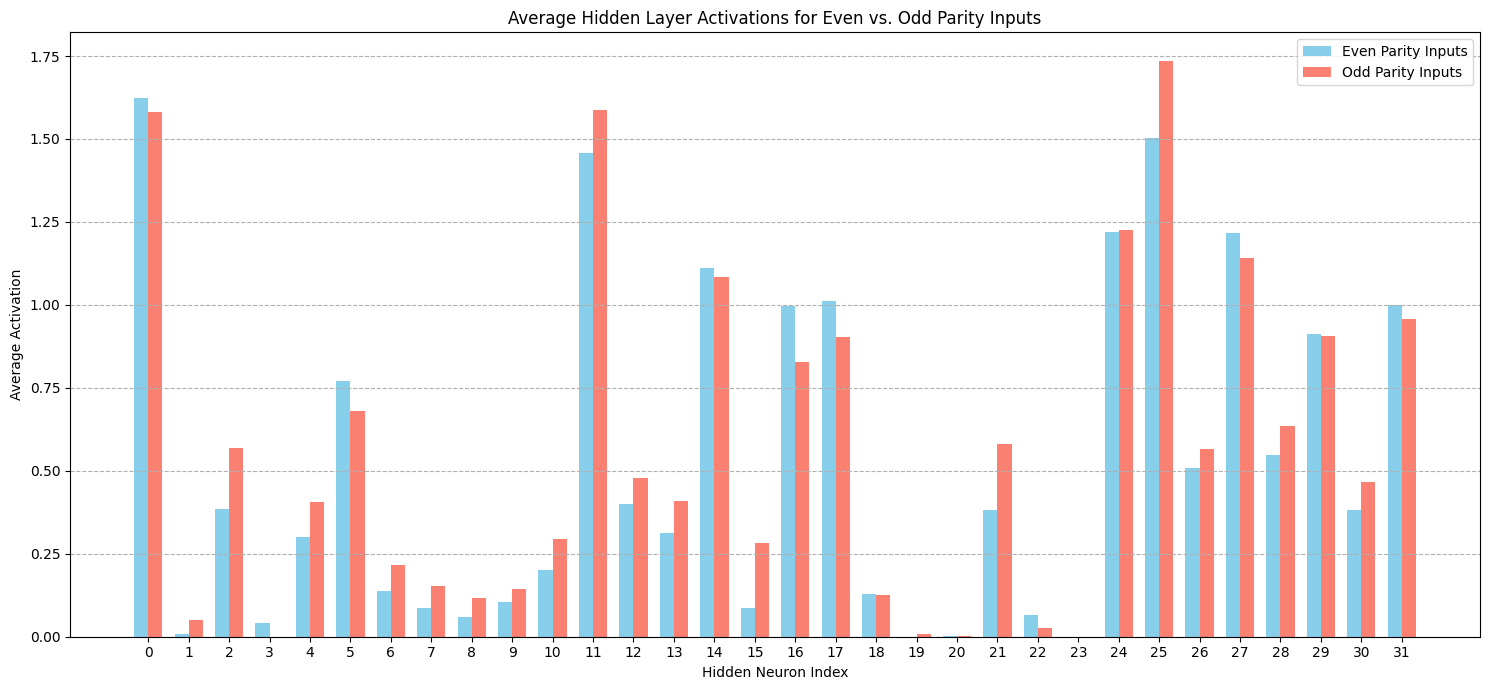

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Gemini helped with the plot on Nov14 00:40
# Combine the average activations for easier plotting
avg_activations_combined = torch.stack((avg_even_activations, avg_odd_activations)).detach().numpy()

num_neurons = avg_even_activations.shape[0]
neuron_indices = np.arange(num_neurons)

plt.figure(figsize=(15, 7))
bar_width = 0.35

plt.bar(neuron_indices - bar_width/2, avg_activations_combined[0], bar_width, label='Even Parity Inputs', color='skyblue')
plt.bar(neuron_indices + bar_width/2, avg_activations_combined[1], bar_width, label='Odd Parity Inputs', color='salmon')

plt.xlabel('Hidden Neuron Index')
plt.ylabel('Average Activation')
plt.title('Average Hidden Layer Activations for Even vs. Odd Parity Inputs')
plt.xticks(neuron_indices)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


The visualization of average hidden layer activations revealed that some hidden neurons exhibit distinct activation patterns for even versus odd parity inputs. Neurons with a large difference in average activation between even and odd parity inputs are likely responsible for distinguishing between these two input types, thus contributing significantly to the model's parity prediction. For instance, neuron #25 shows the biggest difference in average activation, indicating it has learned to respond selectively to the parity characteristics of the input.

There are several neurons have near zero average activation. Despite the possibility that they might be dead and does not contribute significantly to the prediction, some neurons could be designed to be sparsely activated, and only fire for very specific output.

Next, I would conduct a more thorough test to see which neuron is meaningful in this N-bit parity problem.

In [28]:
parity_model.eval()
with torch.no_grad():
    # Select a representative sample input and its true label
    test_input_parity = X_val_parity[0].unsqueeze(0) # Add batch dimension
    true_parity_label = y_val_parity[0].item()

    # Get baseline prediction (logit)
    baseline_logit, _ = parity_model(test_input_parity)
    baseline_logit = baseline_logit.item() # Get the scalar logit value

print(f"Selected Test Input: {test_input_parity.squeeze(0)}")
print(f"True Parity Label: {true_parity_label}")
print(f"Baseline Logit Prediction: {baseline_logit:.4f}")

Selected Test Input: tensor([1., 0., 1., 0., 1., 0., 0., 0.])
True Parity Label: 1
Baseline Logit Prediction: 4.7433


Now that the baseline prediction for a sample input is established, the next step is to perform the neuron ablation sweep. This involves iterating through each hidden neuron, zeroing its activation, and calculating the resulting change in the model's logit prediction compared to the baseline.



In [31]:
num_neurons = parity_model.fc1.out_features
signed_deltas_parity = []

parity_model.eval()
with torch.no_grad():
    # Get the hidden layer activation for the test input once
    _, baseline_h_parity = parity_model(test_input_parity)

    for i in range(num_neurons):
        # Create a copy of the baseline hidden activations
        ablated_h_parity = baseline_h_parity.clone()

        # Zero out the activation of the current neuron
        ablated_h_parity[:, i] = 0

        # Pass the modified hidden activation through the second linear layer
        modified_logit_parity = parity_model.fc2(ablated_h_parity).item()

        # Calculate the difference from the baseline logit
        delta_parity = modified_logit_parity - baseline_logit
        signed_deltas_parity.append(delta_parity)


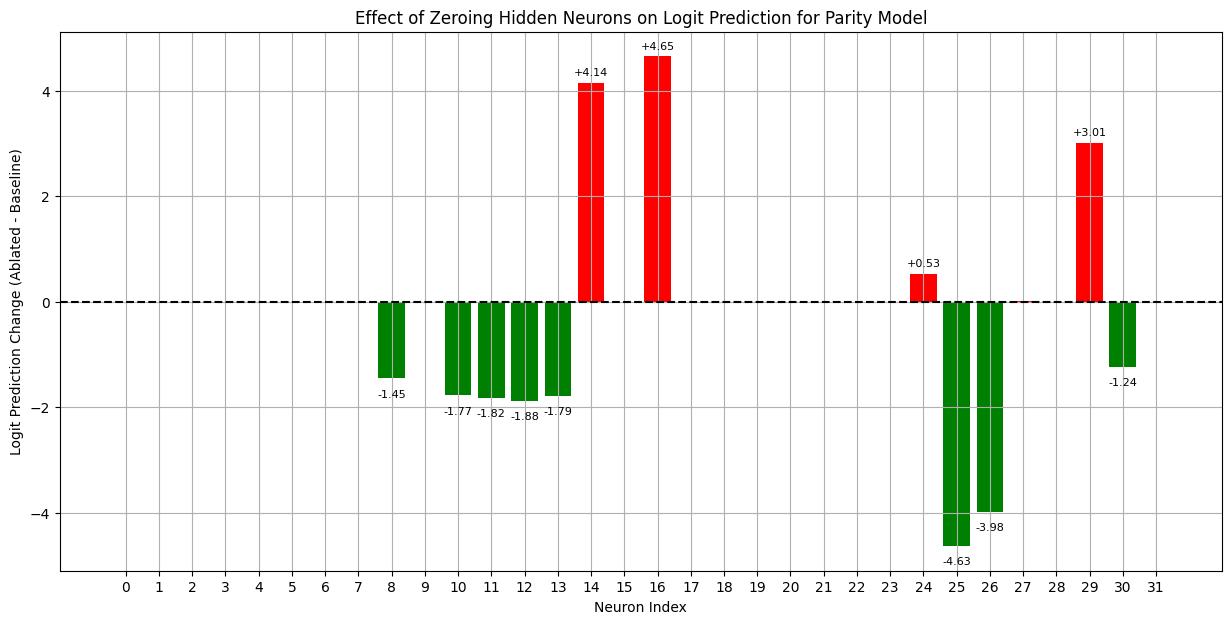

Summary of significant neuron impacts:
Neuron 8 -> Logit prediction decreased by 1.45
Neuron 10 -> Logit prediction decreased by 1.77
Neuron 11 -> Logit prediction decreased by 1.82
Neuron 12 -> Logit prediction decreased by 1.88
Neuron 13 -> Logit prediction decreased by 1.79
Neuron 14 -> Logit prediction increased by 4.14
Neuron 16 -> Logit prediction increased by 4.65
Neuron 24 -> Logit prediction increased by 0.53
Neuron 25 -> Logit prediction decreased by 4.63
Neuron 26 -> Logit prediction decreased by 3.98
Neuron 29 -> Logit prediction increased by 3.01
Neuron 30 -> Logit prediction decreased by 1.24


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
neuron_indices_parity = np.arange(num_neurons)
colors_parity = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas_parity]

# Gemini has prepared for the plot format on Nov14 1:03
plt.figure(figsize=(15, 7))
plt.bar(neuron_indices_parity, signed_deltas_parity, color=colors_parity)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices_parity)
plt.xlabel("Neuron Index")
plt.ylabel("Logit Prediction Change (Ablated - Baseline)")
plt.title("Effect of Zeroing Hidden Neurons on Logit Prediction for Parity Model")
plt.grid(True)

# Annotate significant changes
for i, d in enumerate(signed_deltas_parity):
    if abs(d) > 0.1: # Only annotate changes greater than a threshold for clarity
        plt.text(i, d + (0.1 if d > 0 else -0.2), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top', fontsize=8)

plt.show()

print("Summary of significant neuron impacts:")
for i, d in enumerate(signed_deltas_parity):
    if abs(d) > 0.1: # Define a threshold for 'significant' impact
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} -> Logit prediction {direction} by {abs(d):.2f}")

Because we filter out the neurons with absolute change in predictions less than 0.1, we can form some conclusions at this step...
*   **Which neurons have the most significant impact on the model's prediction for the chosen input?**
    Neurons with the most significant impact (absolute change > 0.1) include: Neuron 16 (increased logit by 4.65), Neuron 25 (decreased logit by 4.63), and others such as 8, 10, 11, 12, 13, 14, 24, 26, 29, and 30, which also showed notable changes.
*   **What do these results suggest about the functional role of individual neurons in the parity problem?**
    The results suggest that certain neurons in the hidden layer play crucial, distinct roles in determining the model's output for the parity problem. For example, the presence of Neuron 16 typically drives the logit prediction downwards, as zeroing it out significantly increased the logit. Conversely, Neuron 25 seems to drive the logit prediction upwards, as its ablation caused a substantial decrease. This indicates that these neurons are not redundant and are actively involved in the complex computation required to determine parity, contributing either positively or negatively to the final decision boundary.

*   Further investigation could involve analyzing the input patterns that strongly activate these identified high-impact neurons (e.g., Neuron 16 and 25) to understand their specific feature detection capabilities related to the parity function.
*   The sensitivity of the model to these specific neurons suggests they could be targets for further analysis, such as visualizing their weights or exploring their interactions within the network, to gain deeper insights into the model's internal representation of the parity problem.


## Reflection

**What did you learn about how your model works?**

I learned that even a simple MLP, when trained on a parity problem, develops specialized neurons in its hidden layer. The ablation study clearly showed that certain neurons have a significant, and often opposite, impact on the logit prediction. For instance, ablating Neuron 16 caused the logit to increase, while ablating Neuron 25 caused it to decrease substantially. This indicates that these neurons are not redundant and are actively involved in computing the parity, each contributing a distinct 'vote' (positive or negative) to the final decision.

**What was confusing, surprising, or challenging to interpret?**

It was initially confusing to see many neurons having zero or near-zero impact upon ablation, as indicated by the missing bars in the plot. However, upon reflection, this highlights that for a given input, not all neurons are active or equally contributing. It was surprising how many neurons had such strong, isolated effects. The concept of 'superposition' (where one neuron might encode multiple features) was a bit challenging to fully grasp and definitively identify within this simple model without more sophisticated analysis techniques. The exact 'meaning' or feature that each high-impact neuron is detecting remains somewhat abstract, even with the change in logit.

**What’s one thing you wish you could understand better or explore further?**

I wish I could better understand and explore what specific input features or patterns each high-impact neuron (like Neuron 16 or 25) is selectively responding to. While we know they influence the parity prediction, identifying the precise combination of bits that maximally activate or de-activate them would provide a deeper mechanistic understanding. This could involve techniques like activation maximization or finding input subsets that trigger these neurons. Furthermore, I'd be interested in seeing if these specialized neurons emerge consistently across different training runs or with different random initializations.